In [1]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from make_line import make_data, get_grid

In [21]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=1024)
x_val, y_val0, y_val1 = make_data(N=100)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

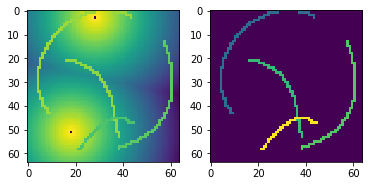

In [22]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,-1]==1)
tmp = np.zeros((szx,szy))
for r in region.squeeze():
    tmp[y_train1[ind,r,:,:].squeeze()==1]=r+1
plt.subplot(122)
plt.imshow(tmp)

In [23]:

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers
import tensorflow as tf
from keras import backend as K

In [1]:
def viz_results(x_test,y_test0,ytest1,pred):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))

        # GROUND TRUTH
        plt.subplot(331)
        plt.title('sample index: {}'.format(ind))
        plt.imshow(x_test[ind,:].squeeze())

        region = np.argwhere(y_test0[ind,:,obj_ind]==1).ravel()
        obj_real = np.zeros((szx,szy))
        for r in region:
            obj_real[grid==r]=1
        obj_real = np.reshape(y_test0[ind,:,obj_ind],(smx,smy))

        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        obj = np.reshape(pred[0][ind,:,obj_ind],(smx,smy))

        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(y_test0[ind,:,obj_ind])
        ax.set_ylim(0,1)

        # PREDICTED
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')

        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(pred[0][ind,:,obj_ind])
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            argmax = np.argmax(pred[0][ind,:,obj_ind])
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,argmax,:,:].squeeze(),cmap='gray')

In [24]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO
# actual yolos
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2
# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py

epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1])

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0], y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1], y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2], y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3], y_pred[...,3])
    loss_pos = tf.multiply(y_true[...,-1],tf.add(loss_px,loss_py))
    loss_width = tf.multiply(y_true[...,-1],tf.add(loss_wx,loss_wy))
    return loss_pos+loss_width

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], intersect_areas / (union_areas+epsilon) )
    
    return iou_loss

# https://github.com/keras-team/keras/issues/3611
def dice_coef(y_true, y_pred, smooth=1e-3):
    intersection = K.sum(y_true * y_pred, axis=[2,3])
    union = K.sum(y_true, axis=[2,3]) + K.sum(y_pred, axis=[2,3])
    return (2. * intersection + smooth) / (union + smooth)

# is_obj = K.sum(y_true, axis=[2,3])
# is_obj = K.cast(K.greater(is_obj,K.zeros_like(is_obj)),tf.float32)
# is_obj = is_obj[...,:]

def dice_coef_loss(y_true, y_pred):    
    dice = dice_coef(y_true, y_pred)
    # get rid of dice where there is no object.
    is_obj = K.sum(y_true, axis=[2,3])
    is_obj = K.greater(is_obj,K.zeros_like(is_obj))
    dice = tf.boolean_mask(dice, is_obj)
    return tf.reduce_mean(1-dice)

def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 1.0
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

# down sample
xd = conv_batch_lrelu(inputs, 32, 3)
xd = conv_batch_lrelu(xd, 64, 3)
xd = conv_batch_lrelu(xd, 128, 3)
xd = conv_batch_lrelu(xd, 256, 3)

# up sample
xu = convt_batch_lrelu(xd,256,3)
xu = convt_batch_lrelu(xu,128,3)
xu = convt_batch_lrelu(xu,64,3)
xu = convt_batch_lrelu(xu,32,3)

# output: mask
xu = Conv2D(64, (3, 3), padding='same')(xu)
masks = Activation("sigmoid", name=MASK)(xu)

# bottle neck
x=Flatten()(xd)
x=Dense(256)(x) # # filter size ratio between conv and dense needs to be tuned!
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)
x=Dense(256)(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=0.1)
x=Dense(smx*smy*5)(x)
x=Reshape((smx*smy,5))(x)

# output split - split output to have varying activations for pos,width, and obj
# output: pos and width
x_pos_width = Lambda(lambda x: x[..., 0:4])(x)
x_pos_width=Activation('linear')(x_pos_width)
x_pos_width=Lambda(lambda x: K.clip(x,0.,1.))(x_pos_width)

# output: sigmoid
x_obj = Lambda(lambda x: K.expand_dims(x[..., -1],axis=-1))(x)
x_obj=Activation('sigmoid')(x_obj)

# merge outputs
vecs = Concatenate(axis=-1,name=VECTOR)([x_pos_width,x_obj])

model = Model(inputs=inputs, outputs=[vecs,masks])
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)

yolo_loss = {
    MASK: dice_coef_loss,
    VECTOR: vec_loss,
}
loss_weights = {
    MASK: 1.,
    VECTOR: 1.,
}


batch_size = 32 # batch size is also a hyperparam.
epochs=100
lr=1E-3
decay=1E-3
beta_1=0.9
beta_2=0.999


early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]

optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)

model.compile(loss=yolo_loss, loss_weights=loss_weights, optimizer=optimizer)
history = model.fit(x_train, {VECTOR:y_train0,MASK:y_train1},
                    batch_size=batch_size, epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, {VECTOR:y_val0, MASK:y_val1}),
                    callbacks=callbacks)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 32)   128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 32, 32, 32)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_7 (

Train on 1024 samples, validate on 100 samples
Epoch 1/100
1024/1024 [==============================] - 5s 5ms/step - loss: 5.4190 - VECTOR_loss: 0.2638 - MASK_loss: 0.9688 - val_loss: 4.3034 - val_VECTOR_loss: 0.1723 - val_MASK_loss: 0.9645
Epoch 2/100
1024/1024 [==============================] - 2s 2ms/step - loss: 3.6241 - VECTOR_loss: 0.1789 - MASK_loss: 0.9630 - val_loss: 2.9921 - val_VECTOR_loss: 0.1592 - val_MASK_loss: 0.9596
Epoch 3/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.5929 - VECTOR_loss: 0.1674 - MASK_loss: 0.9506 - val_loss: 2.2682 - val_VECTOR_loss: 0.1844 - val_MASK_loss: 0.9633
Epoch 4/100
1024/1024 [==============================] - 2s 2ms/step - loss: 1.9921 - VECTOR_loss: 0.1617 - MASK_loss: 0.9383 - val_loss: 1.8214 - val_VECTOR_loss: 0.1651 - val_MASK_loss: 0.9634
Epoch 5/100
1024/1024 [==============================] - 2s 2ms/step - loss: 1.6444 - VECTOR_loss: 0.1588 - MASK_loss: 0.9161 - val_loss: 1.5770 - val_VECTOR_loss: 0.1619 - 

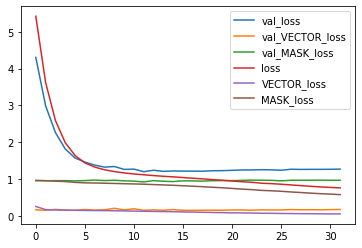

In [25]:
#for k,v in history.history.items():
#    history.history[k]=v/v[0]   
df = pd.DataFrame(history.history)
df.plot()

In [26]:
history.history.keys()

dict_keys(['val_loss', 'val_VECTOR_loss', 'val_MASK_loss', 'loss', 'VECTOR_loss', 'MASK_loss'])

In [2]:

#x_test, y_test0, y_test1 = x_train, y_train0, y_train1
#x_test, y_test0, y_test1 = x_val, y_val0, y_val1
pred = model.predict(x_test)
viz_results(x_test,y_test0,ytest1,pred)

NameError: name 'model' is not defined